# Imports

In [41]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


# Config

In [42]:
import pandas as pd
import glob
from pathlib import Path
import numpy as np

class Config:
    # Date ranges
    TRAIN_START_DATE = "2018-05-02T08:44:39.292059872Z"
    TRAIN_END_DATE = "2018-05-02T23:59:55.940964414Z"
    TEST_START_DATE = "2018-05-02T23:59:55.940964414Z"
    TEST_END_DATE = "2018-05-03T23:59:58.000000Z"

    # Data files
    FILE1 = r"C:\Users\cinco\Desktop\DATA FOR SCRIPTS\data bento data\test\xnas.itch_NVDA_20180502_to_20180503.csv"
    FILE2 = r"C:\Users\cinco\Desktop\DATA FOR SCRIPTS\data bento data\test\xnas.itch_NVDA_20180503_to_20180504.csv"

    # Model parameters
    BATCH_SIZE = 32
    HIDDEN_SIZE = 64
    NUM_LAYERS = 2
    LEARNING_RATE = 0.001
    EPOCHS = 2
    SEQUENCE_LENGTH = 100
    PREDICTION_LENGTH = 30

    # Training parameters
    NUM_WORKERS = 0
    RANDOM_SEED = 42

    @classmethod
    def validate_dates(cls):
        try:
            train_start = pd.to_datetime(cls.TRAIN_START_DATE, utc=True)
            train_end = pd.to_datetime(cls.TRAIN_END_DATE, utc=True) + pd.Timedelta(microseconds=1)
            test_start = pd.to_datetime(cls.TEST_START_DATE, utc=True)
            test_end = pd.to_datetime(cls.TEST_END_DATE, utc=True) + pd.Timedelta(microseconds=1)
            
            print(f"\nValidating date ranges:")
            print(f"Train period: {train_start} to {train_end}")
            print(f"Test period: {test_start} to {test_end}")
            
            assert train_start < train_end, "Training start date must be before training end date"
            assert test_start <= test_end, "Test start date must be before or equal to test end date"
            assert train_end >= test_start, "Training end date should be at or after test start date"
            
            return True
        except Exception as e:
            print(f"Date validation error: {str(e)}")
            return False

    @classmethod
    def analyze_time_series(cls):
        try:
            all_diffs = []
            csv_files = glob.glob(str(Path(cls.DATA_DIR) / "*.csv"))
            
            for file in csv_files:
                df = pd.read_csv(file)
                df['ts_event'] = pd.to_datetime(df['ts_event'])
                df = df.sort_values('ts_event')
                time_diffs = df['ts_event'].diff().dt.total_seconds()
                all_diffs.extend(time_diffs.dropna().tolist())
            
            if not all_diffs:
                raise ValueError("No valid time differences found in the data")
            
            median_diff = np.median(all_diffs)
            mean_diff = np.mean(all_diffs)
            std_diff = np.std(all_diffs)
            
            typical_observations_per_30min = int((30 * 60) / median_diff)
            cls.sequence_length = min(max(typical_observations_per_30min, 10), 100)
            
            typical_observations_per_5min = int((5 * 60) / median_diff)
            cls.prediction_length = min(max(typical_observations_per_5min, 5), 30)
            
            print(f"\nTime Series Analysis Results:")
            print(f"Median time between observations: {median_diff:.2f} seconds")
            print(f"Mean time between observations: {mean_diff:.2f} seconds")
            print(f"Standard deviation: {std_diff:.2f} seconds")
            print(f"Selected sequence length: {cls.sequence_length} observations")
            print(f"Selected prediction length: {cls.prediction_length} observations")
            
            return True
        except Exception as e:
            print(f"Error analyzing time series: {str(e)}")
            cls.sequence_length = 100
            cls.prediction_length = 30
            return False

    @classmethod
    def initialize(cls):
        if not cls.validate_dates():
            raise ValueError("Date validation failed")
        if not cls.analyze_time_series():
            print("Warning: Using default sequence and prediction lengths")
        return True


# Data Loading Function


In [43]:
def load_csv_data(file1, file2, columns=['ts_event', 'price']):
    df1 = pd.read_csv(file1, usecols=columns)
    df2 = pd.read_csv(file2, usecols=columns)
    df = pd.concat([df1, df2], ignore_index=True)
    df['ts_event'] = pd.to_datetime(df['ts_event'], utc=True)
    return df.sort_values('ts_event')

# Data Preprocessing Function


In [44]:
def preprocess_data(df, train_start, train_end, test_start, test_end, sequence_length):
    train_mask = (df['ts_event'] >= train_start) & (df['ts_event'] <= train_end)
    test_mask = (df['ts_event'] > test_start) & (df['ts_event'] <= test_end)

    train_df = df[train_mask]
    test_df = df[test_mask]

    scaler = MinMaxScaler()
    train_prices = scaler.fit_transform(train_df['price'].values.reshape(-1, 1))
    test_prices = scaler.transform(test_df['price'].values.reshape(-1, 1))

    X_train, y_train = create_sequences(train_prices, sequence_length)
    X_test, y_test = create_sequences(test_prices, sequence_length)

    return X_train, y_train, X_test, y_test, scaler, test_df

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)


# Custom Dataset


In [45]:
class PriceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# LSTM Model


In [46]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Training Function


In [47]:
def train_model(model, train_loader, criterion, optimizer):
    model.train()
    for epoch in range(Config.EPOCHS):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{Config.EPOCHS}], Loss: {loss.item():.4f}')

# Prediction Function


In [48]:
def predict(model, test_data, scaler):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for i in range(len(test_data)):
            X = torch.FloatTensor(test_data[i]).unsqueeze(0)
            y_pred = model(X)
            predictions.append(scaler.inverse_transform(y_pred.numpy())[0][0])
    
    return predictions

# Visualization

In [49]:
def plot_predicted_vs_actual(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['ts_event'], df['actual_price'], label='Actual Price')
    plt.plot(df['ts_event'], df['predicted_price'], label='Predicted Price')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title('Predicted vs Actual Prices')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    rmse = np.sqrt(((df['actual_price'] - df['predicted_price']) ** 2).mean())
    print(f"Root Mean Square Error: {rmse}")

# Main execution


Epoch [1/2], Loss: 0.0003
Epoch [2/2], Loss: 0.0012


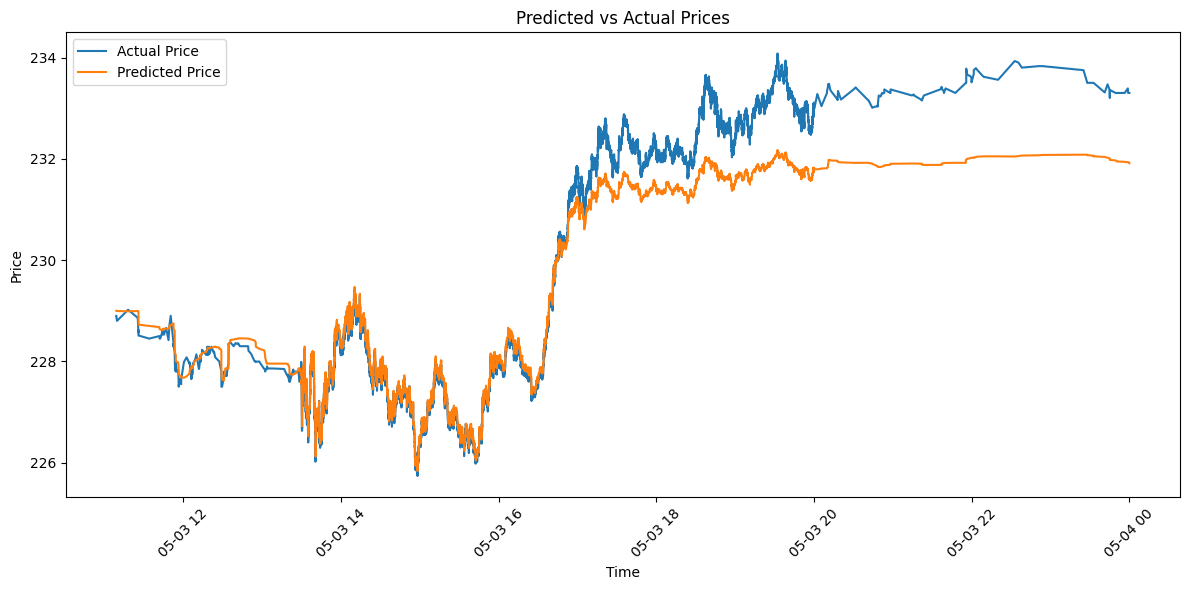

Root Mean Square Error: 0.7208409466653319
                                 ts_event  predicted_price  actual_price
0     2018-05-03 11:09:02.609753626+00:00       228.998825        228.90
1     2018-05-03 11:09:02.617097558+00:00       228.996429        228.90
2     2018-05-03 11:09:02.914019348+00:00       228.995483        228.90
3     2018-05-03 11:09:34.115697846+00:00       228.995377        228.80
4     2018-05-03 11:18:01.992699660+00:00       228.988159        229.02
...                                   ...              ...           ...
42014 2018-05-03 23:59:51.388549226+00:00       231.917862        233.30
42015 2018-05-03 23:59:52.108005539+00:00       231.916565        233.30
42016 2018-05-03 23:59:55.645684828+00:00       231.915543        233.30
42017 2018-05-03 23:59:56.803544874+00:00       231.914719        233.30
42018 2018-05-03 23:59:57.562957996+00:00       231.914108        233.30

[42019 rows x 3 columns]


In [50]:

if __name__ == "__main__":
    # Load data
    df = load_csv_data(Config.FILE1, Config.FILE2)

    # Preprocess data
    train_start = pd.to_datetime(Config.TRAIN_START_DATE, utc=True)
    train_end = pd.to_datetime(Config.TRAIN_END_DATE, utc=True)
    test_start = pd.to_datetime(Config.TEST_START_DATE, utc=True)
    test_end = pd.to_datetime(Config.TEST_END_DATE, utc=True)

    X_train, y_train, X_test, y_test, scaler, test_df = preprocess_data(
        df, train_start, train_end, test_start, test_end, Config.SEQUENCE_LENGTH
    )
    
    # Create dataset and dataloader for training data
    train_dataset = PriceDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.NUM_WORKERS)
    
    # Initialize model, loss function, and optimizer
    model = LSTMModel(hidden_size=Config.HIDDEN_SIZE, num_layers=Config.NUM_LAYERS)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)
    
    # Train the model
    train_model(model, train_loader, criterion, optimizer)
    
    # Make predictions on test data
    test_predictions = predict(model, X_test, scaler)
    
    # Create a DataFrame with test predictions
    predictions_df = pd.DataFrame({
        'ts_event': test_df['ts_event'][Config.SEQUENCE_LENGTH:].reset_index(drop=True),
        'predicted_price': test_predictions,
        'actual_price': test_df['price'][Config.SEQUENCE_LENGTH:].reset_index(drop=True)
    })
    
    # Plot predicted vs actual prices
    plot_predicted_vs_actual(predictions_df)
    
    print(predictions_df)